Reference: https://qiita.com/everylittle/items/ba821e93d275a421ca2b  
  
RNN(LSTM) を試す、列の総和を出力するモデル  
可変長の場合

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Masking, LSTM
#from keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import Adam
import numpy as np
import random

In [3]:
input_dim = 1                # 入力データの次元数：実数値1個なので1を指定
output_dim = 1               # 出力データの次元数：同上
num_hidden_units = 128       # 隠れ層のユニット数
batch_size = 300             # ミニバッチサイズ
num_of_training_epochs = 100 # 学習エポック数
learning_rate = 0.001        # 学習率
num_training_samples = 1000  # 学習データのサンプル数

In [4]:
def create_data(nb_of_samples):
    # 長さを対数正規分布に従って決める
    leng = np.around(np.random.lognormal(np.log(5.0), 0.5, (nb_of_samples, 1))).astype("int")
    max_sequence_len = leng.max()
 
    # 乱数で {0.0, 1.0} の列を生成する
    X = np.random.randint(0, 2, (nb_of_samples, max_sequence_len)).astype("float32")

    # 長さを超えた部分を-1.0に置き換える
    X[np.arange(max_sequence_len).reshape((1, -1)) >= leng] = -1.0

    # 各行の-1.0を除いた総和を正解ラベルとする
    t = np.ma.array(X, mask=(X == -1.0)).sum(axis=1)

    # LSTMに与える入力は (サンプル, 時刻, 特徴量の次元) の3次元になる。
    return X.reshape((nb_of_samples, max_sequence_len, 1)), t

In [5]:
random.seed(0)
np.random.seed(0)
#tf.set_random_seed(0)
tf.random.set_seed(0)

In [6]:
X, t = create_data(num_training_samples)

In [7]:
print(X.shape)
print(t.shape)

(1000, 20, 1)
(1000,)


In [8]:
X[0]

array([[ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]], dtype=float32)

In [9]:
t[0]

7.0

In [11]:
#X.reshape(X.shape[:-1])

import pandas as pd
df = pd.DataFrame(X.reshape(X.shape[:-1]))
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [12]:
df2 = pd.concat([df, pd.Series(t, name='t')], axis=1)
df2.tail()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,t
995,1.0,0.0,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0
996,1.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.0
997,0.0,0.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.0
998,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0
999,0.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.0


In [18]:
model = Sequential()

# パディングの値を指定してMaskingレイヤーを作成する
model.add(Masking(input_shape=(None, input_dim), mask_value=-1.0))

model.add(LSTM(num_hidden_units, return_sequences=False))

model.add(Dense(output_dim))

model.compile(loss="mean_squared_error", optimizer=Adam(lr=learning_rate))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, None, 1)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [19]:
hist = model.fit(X,
                 t,
                 batch_size=batch_size,
                 epochs=num_of_training_epochs,
                 validation_split=0.1)

Epoch 1/100
3/3 [==============================] - 1s 306ms/step - loss: 10.9350 - val_loss: 12.4963
Epoch 2/100
3/3 [==============================] - 0s 38ms/step - loss: 10.0520 - val_loss: 11.4277
Epoch 3/100
3/3 [==============================] - 0s 37ms/step - loss: 9.0874 - val_loss: 10.1239
Epoch 4/100
3/3 [==============================] - 0s 37ms/step - loss: 7.8795 - val_loss: 8.2517
Epoch 5/100
3/3 [==============================] - 0s 38ms/step - loss: 6.0941 - val_loss: 5.2476
Epoch 6/100
3/3 [==============================] - 0s 38ms/step - loss: 3.6589 - val_loss: 2.2418
Epoch 7/100
3/3 [==============================] - 0s 37ms/step - loss: 1.7446 - val_loss: 1.6928
Epoch 8/100
3/3 [==============================] - 0s 36ms/step - loss: 1.7206 - val_loss: 2.4009
Epoch 9/100
3/3 [==============================] - 0s 37ms/step - loss: 1.8592 - val_loss: 2.1370
Epoch 10/100
3/3 [==============================] - 0s 37ms/step - loss: 1.4684 - val_loss: 1.5822
Epoch 11/100


Epoch 84/100
3/3 [==============================] - 0s 40ms/step - loss: 0.0591 - val_loss: 0.0640
Epoch 85/100
3/3 [==============================] - 0s 41ms/step - loss: 0.0576 - val_loss: 0.0647
Epoch 86/100
3/3 [==============================] - 0s 40ms/step - loss: 0.0567 - val_loss: 0.0614
Epoch 87/100
3/3 [==============================] - 0s 39ms/step - loss: 0.0554 - val_loss: 0.0597
Epoch 88/100
3/3 [==============================] - 0s 40ms/step - loss: 0.0545 - val_loss: 0.0640
Epoch 89/100
3/3 [==============================] - 0s 39ms/step - loss: 0.0548 - val_loss: 0.0616
Epoch 90/100
3/3 [==============================] - 0s 39ms/step - loss: 0.0537 - val_loss: 0.0684
Epoch 91/100
3/3 [==============================] - 0s 39ms/step - loss: 0.0532 - val_loss: 0.0580
Epoch 92/100
3/3 [==============================] - 0s 42ms/step - loss: 0.0539 - val_loss: 0.0548
Epoch 93/100
3/3 [==============================] - 0s 43ms/step - loss: 0.0520 - val_loss: 0.0511
Epoch 94/1

<AxesSubplot:>

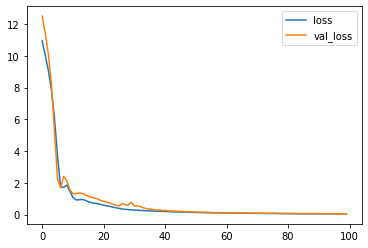

In [20]:
import pandas as pd

results = pd.DataFrame(hist.history)
results[['loss', 'val_loss']].plot()

In [21]:
test = np.array([1, 1, 1, 0, 1, 0, 1]).astype("float32")

# (a) 長さを変えずに入力
print(model.predict(test.reshape((1, -1, 1))))

[[4.8063693]]


In [22]:
# (b) 後ろに適当な数の-1.0を追加して入力
print(model.predict(np.pad(test, (0, 10), "constant", constant_values=-1.0).reshape((1, -1, 1))))

[[4.8063693]]
